<a href="https://colab.research.google.com/github/nikhildr22/Speech-Emotion-Recognition/blob/master/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
''' Using Tensorflow 1.x '''

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
''' listing directories '''
!ls

sample_data


In [0]:
''' Downloading the dataset from the website in zip compressed format '''
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2020-05-03 21:58:51--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  46.8MB/s    in 3.8s    

2020-05-03 21:58:55 (52.9 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [0]:
''' creating a folder - 'dataset' to keep the data '''
!mkdir dataset
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [0]:
''' unzipping the dataset into the destination folder 'dataset' '''
!unzip -q Audio_Speech_Actors_01-24.zip -d dataset

In [0]:
''' listing directories '''
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [0]:
''' Installing soundfile module via pip '''
!pip install soundfile

In [0]:
''' importing required modules '''
import librosa
from tqdm import tqdm
import soundfile
from scipy.io import wavfile
import os, glob, pickle
import numpy as np
from scipy.fftpack import dct
import matplotlib.pyplot as plt

In [0]:
''' creating a directory to keep clean files '''
!mkdir clean 

In [0]:
''' downsampling audio files to 16KHz and storing them in /clean directory ''' 
for f in tqdm(glob.glob("dataset/*/*")):
    signal, rate = librosa.load(path=f, sr=16000)
    wavfile.write(filename='clean/'+f[-24:],rate=rate,data=signal)

100%|██████████| 1440/1440 [05:29<00:00,  4.37it/s]


In [0]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to be observed in our project
observed_emotions=['sad','angry','happy','neutral']

In [0]:
''' Creating a pandas dataframe for structured handling of files in the dataset '''
import pandas as pd
#Dataframe will contain 2 columns 'file' and 'emotion'
dataframe = pd.DataFrame(columns=['file', 'emotion'])

In [0]:
''' filling the dataframe rows with values '''
for file in tqdm(glob.glob("clean/*")):
        file_name=os.path.basename(file[-24:])
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue

        dataframe = dataframe.append({'file': file, 'emotion': emotion}, ignore_index=True)

100%|██████████| 1440/1440 [00:02<00:00, 602.70it/s]


In [0]:
dataframe.describe()

,file,emotion
count,672,672
unique,672,4
top,clean/03-01-05-02-02-02-23.wav,angry
freq,1,192


In [0]:
''' Dividing the dataframe into test and train dataframes '''
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)

In [0]:
train.describe()

,file,emotion
count,537,537
unique,537,4
top,clean/03-01-04-01-02-02-07.wav,angry
freq,1,154


In [0]:
train.head()

,file,emotion
124,clean/03-01-04-02-01-01-04.wav,sad
507,clean/03-01-04-01-02-01-03.wav,sad
327,clean/03-01-05-01-01-01-05.wav,angry
533,clean/03-01-04-01-02-02-04.wav,sad
92,clean/03-01-04-02-02-02-10.wav,sad


In [0]:
test.describe()

,file,emotion
count,135,135
unique,135,4
top,clean/03-01-05-02-02-02-23.wav,sad
freq,1,41


In [0]:
''' Defining a function for MFCC feature extraction '''

def find_mfcc(signal, sample_rate , numcep):
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_size = 0.025
    frame_stride = 0.01

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    num_ceps = numcep
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-27
   
    return mfcc

In [0]:
''' preparing the training data for the model '''
x_train = []
y_train = []
for index,row in tqdm(train.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            mfcc = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
            x_train.append(mfcc)
            y_train.append(emotion)


537it [00:06, 88.05it/s]


In [0]:
''' preparing the testing data for the model '''
x_test = []
y_test = []
for index,row in tqdm(test.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            mfcc = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
            x_test.append(mfcc)
            y_test.append(emotion)

135it [00:01, 87.35it/s]


In [0]:
''' converting all the training and testing data into numpy arrays '''
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [0]:
'''Performing LabelEncoding for the categorical output data '''
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [0]:
label = LabelEncoder()
y_train = np_utils.to_categorical(label.fit_transform(y_train))
y_test = np_utils.to_categorical(label.fit_transform(y_test))

In [0]:
print('x_train shape = ',x_train.shape)
print('y_train shape = ',y_train.shape)
print('x_test shape = ',x_test.shape)
print('y_test shape = ',y_test.shape)

x_train shape =  (537, 26)
y_train shape =  (537, 4)
x_test shape =  (135, 26)
y_test shape =  (135, 4)


In [0]:
num_features = x_train.shape[1]
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 26


In [0]:
''' imports required for MLP classifier '''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [0]:
#Initializing the Multi Layer Perceptron Classifier
MLP_model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                    hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500,verbose=1)

In [0]:
#Training the model
MLP_model.fit(x_train,y_train)

Iteration 1, loss = 6.37796659
Iteration 2, loss = 2.95408117
Iteration 3, loss = 3.25866837
Iteration 4, loss = 3.41737880
Iteration 5, loss = 2.91619019
Iteration 6, loss = 2.28870041
Iteration 7, loss = 2.18342264
Iteration 8, loss = 2.34827166
Iteration 9, loss = 2.10534039
Iteration 10, loss = 1.91637402
Iteration 11, loss = 1.92187997
Iteration 12, loss = 1.87418741
Iteration 13, loss = 1.79848461
Iteration 14, loss = 1.77526998
Iteration 15, loss = 1.74750065
Iteration 16, loss = 1.73860018
Iteration 17, loss = 1.70669728
Iteration 18, loss = 1.67213368
Iteration 19, loss = 1.67871510
Iteration 20, loss = 1.64431611
Iteration 21, loss = 1.65155251
Iteration 22, loss = 1.64512078
Iteration 23, loss = 1.57980254
Iteration 24, loss = 1.61752447
Iteration 25, loss = 1.58393430
Iteration 26, loss = 1.55652276
Iteration 27, loss = 1.53838664
Iteration 28, loss = 1.53579541
Iteration 29, loss = 1.50307880
Iteration 30, loss = 1.53362953
Iteration 31, loss = 1.48672439
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [0]:
#Predicting the results for the test set data
y_pred=MLP_model.predict(x_test)

In [0]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 60.00%


In [0]:
''' imports required for CNN model '''
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten 
from tensorflow.keras.layers import MaxPooling1D,Dropout

In [0]:
''' reshaping data before feeding into the model '''
input_shape = (num_features,1)
num_files = x_train.shape[0]
x_train = x_train.reshape(num_files,num_features,1)

In [0]:
''' CNN model '''
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=(3), input_shape=input_shape))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(128, kernel_size=(3)))
cnn_model.add(MaxPooling1D(3))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(32, kernel_size=(3)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(12, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))

In [0]:
''' compiling the model and printing summary '''
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 24, 32)            128       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 22, 64)            6208      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 20, 128)           24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 4, 64)             24640     
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2, 32)             6176      
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)               

In [0]:
''' CNN model training '''
final = cnn_model.fit(x_train, y_train, epochs=500,verbose=1, batch_size=256, validation_split=0.2)

Train on 429 samples, validate on 108 samples
Epoch 1/500
429/429 [==============================] - 0s 718us/sample - loss: 2.1028 - acc: 0.2028 - val_loss: 1.3920 - val_acc: 0.2963
Epoch 2/500
429/429 [==============================] - 0s 44us/sample - loss: 1.4568 - acc: 0.2751 - val_loss: 1.3521 - val_acc: 0.2500
Epoch 3/500
429/429 [==============================] - 0s 43us/sample - loss: 1.3936 - acc: 0.2984 - val_loss: 1.3394 - val_acc: 0.2870
Epoch 4/500
429/429 [==============================] - 0s 44us/sample - loss: 1.4320 - acc: 0.2634 - val_loss: 1.3225 - val_acc: 0.3241
Epoch 5/500
429/429 [==============================] - 0s 42us/sample - loss: 1.4044 - acc: 0.2867 - val_loss: 1.3115 - val_acc: 0.3241
Epoch 6/500
429/429 [==============================] - 0s 42us/sample - loss: 1.3422 - acc: 0.2984 - val_loss: 1.3032 - val_acc: 0.3333
Epoch 7/500
429/429 [==============================] - 0s 41us/sample - loss: 1.3381 - acc: 0.3217 - val_loss: 1.2963 - val_acc: 0.3426
E

In [0]:
''' reshaping testing data before feeding into the model '''
num_testfiles = y_test.shape[0]
x_test = x_test.reshape(num_testfiles,num_features,1)

In [0]:
''' evaluating the testing accuracy for the trained model '''
test_loss,test_accuracy = cnn_model.evaluate(x_test, y_test)
print('Testing accuracy is :',test_accuracy*100,'%')

135/135 [==============================] - 0s 132us/sample - loss: 1.4929 - acc: 0.7333
Testing accuracy is : 73.33333492279053 %


In [0]:
''' imports required for playing sound files '''
import IPython.display as ipd

In [0]:
''' taking a random file from the testing data '''
random_data = test.sample()
file = random_data.iloc[0]['file']
print('file ',file[-24:])
original_emotion = random_data.iloc[0]['emotion']
ipd.Audio(filename=file,) # load a local WAV file

file  03-01-05-01-01-02-19.wav


In [0]:
''' extracting features from the random file and feeding it to the model for prediction '''
with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            feature = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
result = cnn_model.predict_classes(feature.reshape(1,num_features,1))
print('Original emotion is : ' + original_emotion)
print('identified emotion is : ' + label.inverse_transform(result)[0])

Original emotion is : angry
identified emotion is : happy


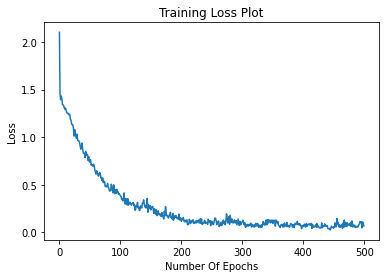

In [0]:
plt.plot(final.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Number Of Epochs')
plt.title('Training Loss Plot')
plt.show()

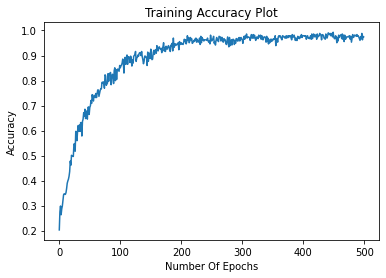

In [0]:
plt.plot(final.history['acc'])
plt.ylabel('Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Training Accuracy Plot')
plt.show()

In [0]:
print('predicted values for the test data: ',label.inverse_transform(cnn_model.predict_classes(x_test.reshape(len(x_test),num_features,1))))

predicted values for the test data:  ['sad' 'sad' 'happy' 'sad' 'angry' 'angry' 'sad' 'happy' 'happy' 'neutral'
 'happy' 'sad' 'happy' 'sad' 'happy' 'happy' 'happy' 'happy' 'happy'
 'angry' 'neutral' 'angry' 'neutral' 'angry' 'neutral' 'neutral' 'angry'
 'angry' 'angry' 'angry' 'angry' 'angry' 'sad' 'sad' 'sad' 'sad' 'neutral'
 'happy' 'neutral' 'happy' 'angry' 'neutral' 'angry' 'angry' 'happy' 'sad'
 'happy' 'happy' 'sad' 'sad' 'sad' 'angry' 'sad' 'angry' 'happy' 'neutral'
 'happy' 'angry' 'sad' 'sad' 'angry' 'sad' 'happy' 'happy' 'sad' 'neutral'
 'happy' 'angry' 'angry' 'angry' 'sad' 'happy' 'angry' 'happy' 'angry'
 'angry' 'happy' 'angry' 'sad' 'angry' 'happy' 'angry' 'sad' 'angry'
 'angry' 'neutral' 'sad' 'happy' 'angry' 'sad' 'happy' 'angry' 'happy'
 'angry' 'sad' 'happy' 'happy' 'angry' 'happy' 'angry' 'happy' 'happy'
 'angry' 'angry' 'happy' 'angry' 'sad' 'happy' 'sad' 'angry' 'angry'
 'happy' 'sad' 'angry' 'neutral' 'happy' 'happy' 'sad' 'happy' 'happy'
 'angry' 'happy' 'sad' '

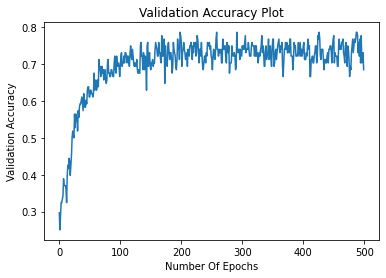

In [0]:
plt.plot(final.history['val_acc'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Validation Accuracy Plot')
plt.show()

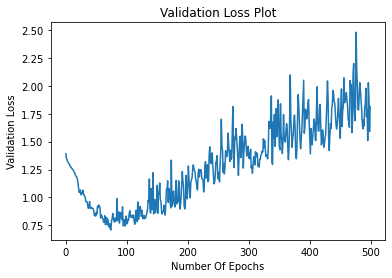

In [0]:
plt.plot(final.history['val_loss'])
plt.ylabel('Validation Loss')
plt.xlabel('Number Of Epochs')
plt.title('Validation Loss Plot')
plt.show()

In [0]:
compare_data = pd.DataFrame(columns=['File', 'Original Emotion', 'Predicted Emotion'])

In [0]:
for index,row in tqdm(test.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            feature = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
            result = cnn_model.predict_classes(feature.reshape(1,num_features,1))
            compare_data = compare_data.append({'File': file, 'Original Emotion': emotion ,'Predicted Emotion':label.inverse_transform(result)[0] }, ignore_index=True)

135it [00:02, 45.00it/s]


In [0]:
''' printing 10 random samples of prediction '''
print(compare_data.sample(10))

                               File Original Emotion Predicted Emotion
37   clean/03-01-04-01-01-01-07.wav              sad             happy
89   clean/03-01-04-02-01-01-21.wav              sad               sad
54   clean/03-01-01-01-01-01-09.wav          neutral             happy
116  clean/03-01-03-02-01-02-02.wav            happy             happy
130  clean/03-01-04-02-01-02-11.wav              sad               sad
13   clean/03-01-04-02-01-01-11.wav              sad               sad
55   clean/03-01-01-01-01-01-08.wav          neutral           neutral
103  clean/03-01-05-02-02-02-19.wav            angry             angry
10   clean/03-01-03-01-01-02-06.wav            happy             happy
58   clean/03-01-01-01-02-01-11.wav          neutral               sad
